In [1]:
from Annotation_helper import *
import numpy as np
from collections import defaultdict
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
# from sklearnex import patch_sklearn 

# patch_sklearn()

# Helper functions

In [3]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

In [4]:
def evaluate_prediction(pred, y_true):
    cm = confusion_matrix(y_true, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    print("recall score: ", recall_score(y_true, pred))
    print("precision score: ", precision_score(y_true, pred))
    print("f1 score: ", f1_score(y_true, pred))

def fit_and_test_classifier(clf, X_train, y_train, y_true):
    clf = clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    
    evaluate_prediction(pred, y_true)
    
    display = PrecisionRecallDisplay.from_estimator(
        clf, X_test, y_test, name="Linear Regression"
    )
    _ = display.ax_.set_title("2-class Precision-Recall curve")
    return clf

# Loading data

In [5]:
matches = pd.read_csv("Matches/Bas3.csv", index_col=0)
# dist_folder = "Distances_jw"
dist_folder = "Distances_levenshtein"

In [6]:
distances = pd.read_csv(dist_folder + "/distances_0.csv", dtype={'permission_indx': 'uint16', 'transaction_indx': 'uint16', 'SlaafGender': 'bool', 'SlaafNaamNieuw': 'float16', 'BezitterGender': 'bool', 'BezitterVoornaam': 'float16', 'BezitterBeroep': 'float16', 'BezitterAchternaam': 'float16'})
for i in range(1, 99):
    df2 = pd.read_csv(f"{dist_folder}/distances_{i}.csv", dtype={'permission_indx': 'uint16', 'transaction_indx': 'uint16', 'SlaafGender': 'bool', 'SlaafNaamNieuw': 'float16', 'BezitterGender': 'bool', 'BezitterVoornaam': 'float16', 'BezitterBeroep': 'float16', 'BezitterAchternaam': 'float16'})
    distances = pd.concat([distances, df2])
distances.reset_index(inplace=True)

In [7]:
len(matches[matches['transaction_indx'] != 'None']["permission_indx"].unique())

40

In [8]:
matches[matches['transaction_indx'] != 'None']

,Annotator,transaction_indx,permission_indx
30,Bas,4097,32
31,Bas,4242,33
32,Bas,4242,33
33,Bas,4228,34
37,Bas,4220,38
39,Bas,4202,40
40,Bas,4202,40
42,Bas,4217,42
43,Bas,4182,43
44,Bas,4219,44


In [9]:
X = distances[distances['permission_indx'].isin(matches["permission_indx"].unique())]
X["Match"] = 0
for i, match in matches.iterrows():
    if match["transaction_indx"] != "None":
        indx = distances.query(f"permission_indx == {match['permission_indx']} & transaction_indx == {match['transaction_indx']}").index
        X.loc[indx, "Match"] = 1
data = X.to_numpy().astype("float")[:, 2:-1]
y = X.to_numpy().astype("float")[:, -1]
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=42)

<ipython-input-9-b5019eb2ad95>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Match"] = 0
C:\Users\basvd\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [10]:
Classifiers = dict()

# Normalizing data

# Oversampling

In [11]:
# ros = RandomOverSampler()
# ros = SMOTE()
# X_train, y_train = ros.fit_resample(X_train, y_train)

# Rule based

In [54]:
class Rule_based_classifier():
    def __init__(self, alg):
        self.alg = alg
        
    def predict_proba(self, X_test):
        pred = self.alg(X_test)
        return pred
    
    def predict(self, X_test, thresh):
        pred = self.alg(X_test)
        return (pred >= thresh).astype(float)

## Exact match

In [55]:
def exact_match(X_test):
    pred = []
    for x in X_test:
        pred.append((x == 1.).sum())
    return np.array(pred)/X_test.shape[1]

In [56]:
EM = Rule_based_classifier(exact_match)
pred = EM.predict(X_test, 0.5)

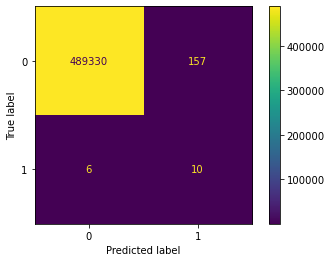

recall score:  0.625
precision score:  0.059880239520958084
f1 score:  0.10928961748633881


In [57]:
evaluate_prediction(pred, y_test)

In [58]:
Classifiers["Exact Match"] = EM

# Fuzzy match

In [59]:
def fuzzy_match(X_test):
    pred = []
    for x in X_test:
        pred.append((x > 0.8).sum())
    return np.array(pred)/X_test.shape[1]

In [71]:
FM = Rule_based_classifier(fuzzy_match)
pred = FM.predict(X_test, 1.)

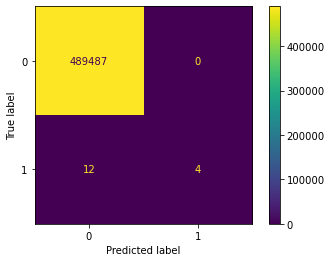

recall score:  0.25
precision score:  1.0
f1 score:  0.4


In [72]:
evaluate_prediction(pred, y_test)

In [62]:
Classifiers["Fuzzy Match"] = FM

# All 0

In [19]:
pred = np.zeros(len(y_test))
pred

array([0., 0., 0., ..., 0., 0., 0.])

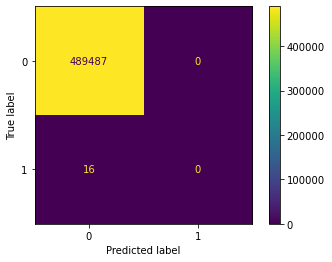

recall score:  0.0
precision score:  0.0
f1 score:  0.0


C:\Users\basvd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
evaluate_prediction(pred, y_test)

# K nearest neighbors

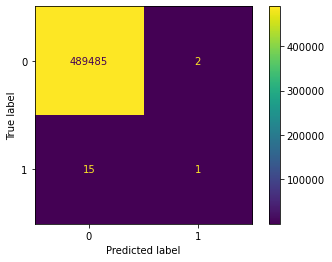

recall score:  0.0625
precision score:  0.3333333333333333
f1 score:  0.10526315789473684


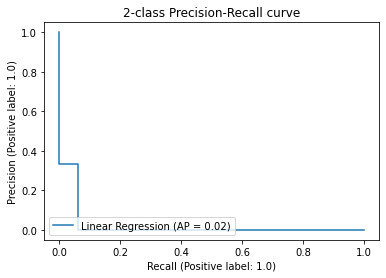

In [21]:
from sklearn.neighbors import KNeighborsClassifier
KNNClf = fit_and_test_classifier(KNeighborsClassifier(n_neighbors=1), X_train, y_train, y_test)

Classifiers["KNeigbors classifier"] = KNNClf

# Logistic regression

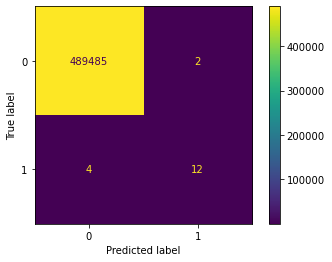

recall score:  0.75
precision score:  0.8571428571428571
f1 score:  0.7999999999999999


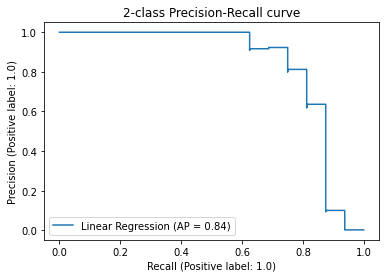

In [22]:
from sklearn.linear_model import LogisticRegression

est = make_pipeline(StandardScaler(), LogisticRegression())
LGClf = fit_and_test_classifier(est, X_train, y_train, y_test)

Classifiers["Logistic Regression"] = LGClf

# Naive Bayes

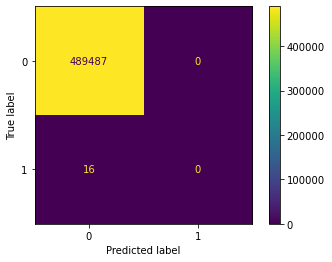

recall score:  0.0
precision score:  0.0


C:\Users\basvd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score:  0.0


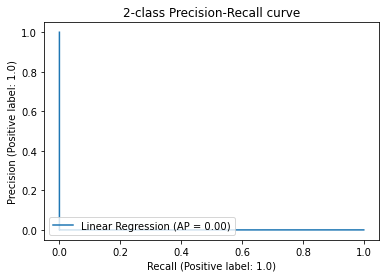

In [23]:
from sklearn.naive_bayes import MultinomialNB

est = make_pipeline(Normalizer(), MultinomialNB())
NBClf = fit_and_test_classifier(est, X_train, y_train, y_test)

Classifiers["Naive Bayes"] = NBClf

# SVM

In [24]:
# from sklearn.svm import SVC
# fit_and_test_classifier(SVC(gamma=2, C=1), X_train, y_train, y_test)

# New technique

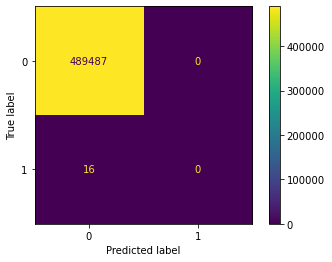

recall score:  0.0
precision score:  0.0


C:\Users\basvd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score:  0.0


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier(loss='perceptron'))])

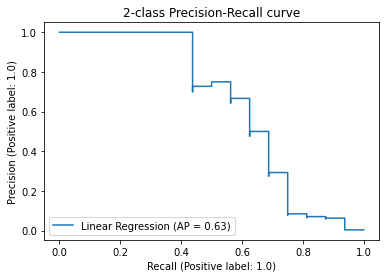

In [25]:
from sklearn.linear_model import SGDClassifier
est = make_pipeline(StandardScaler(), SGDClassifier(loss='perceptron'))

fit_and_test_classifier(est, X_train, y_train, y_test)

# Evaluating results

In [26]:
from sklearn.neural_network import MLPClassifier

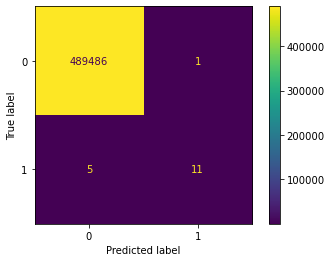

recall score:  0.6875
precision score:  0.9166666666666666
f1 score:  0.7857142857142857


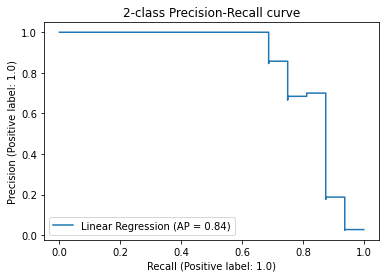

In [27]:
est = make_pipeline(StandardScaler(), MLPClassifier(activation='relu', solver='adam', alpha=1e-5, hidden_layer_sizes=(300, 300), learning_rate='adaptive', random_state=1, verbose=False))

NNClf = fit_and_test_classifier(est, X_train, y_train, y_test)
Classifiers["Neural network"] = NNClf

In [28]:
# est = make_pipeline(StandardScaler(), MLPClassifier(activation='relu', solver='sgd', alpha=1e-5, hidden_layer_sizes=(300, 300), learning_rate='adaptive', random_state=1, verbose=True))

# fit_and_test_classifier(est, X_train, y_train, y_test)

# Tensorflow

In [29]:
# import tensorflow as tf
# from tensorflow import keras
# import tensorflow_transform as tft

# tf.compat.v1.disable_eager_execution()

In [30]:
# tft.scale_to_0_1(y_train)

In [31]:
# model = tf.keras.Sequential([
#     tf.keras.layers.InputLayer(X_train.shape[-1]),
#     tf.keras.layers.Dense(3, activation='relu'),
#     tf.keras.layers.Dense(3, activation='relu'),
#     tf.keras.layers.Dense(3, activation='relu'),
#     tf.keras.layers.Dense(1, activation='softmax'),
# ])

In [32]:
# model.compile("adam", loss='binary_crossentropy', metrics=["Accuracy"])

In [33]:
# model.fit(X_train, tft.scale_to_0_1(y_train), steps_per_epoch=10)

In [34]:
# est = make_pipeline(StandardScaler(), model)

# fit_and_test_classifier(est, X_train, y_train, y_test)

In [35]:
# model.fit(X_train, y_train, batch_size = 128)

In [36]:
# pred = model.predict(X_test)
# cm = confusion_matrix(y_test, pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()

In [37]:
# roc curve and auc on an imbalanced dataset
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.716


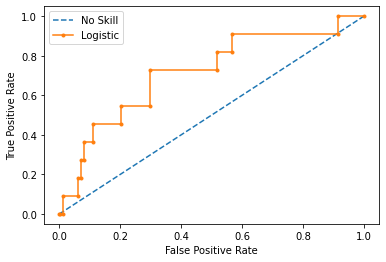

In [38]:
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, weights=[0.99,0.01], random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [39]:
# from sklearn.linear_model import LogisticRegression

# model = make_pipeline(StandardScaler(), LogisticRegression())
# model = fit_and_test_classifier(model, X_train, y_train, y_test)

Exact Match: ROC AUC=0.985
Fuzzy Match: ROC AUC=0.986
KNeigbors classifier: ROC AUC=0.531
Logistic Regression: ROC AUC=0.999
Naive Bayes: ROC AUC=0.830
Neural network: ROC AUC=1.000
No Skill: ROC AUC=0.500


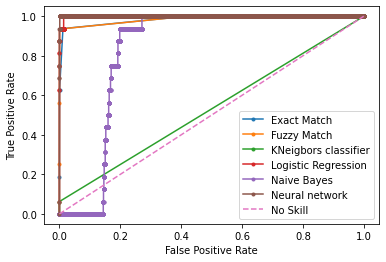

In [52]:
for name in Classifiers:
    model = Classifiers[name]
#     print("name:", name)
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
#     print("lr_probs", lr_probs)
    if type(lr_probs[0]) == np.ndarray:
        lr_probs = lr_probs[:, 1]
    # calculate scores
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print(name + ': ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label=name)
    
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
print('No Skill: ROC AUC=%.3f' % (ns_auc))

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()